In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_parquet("tripdata_combined.parquet")
print(df.head().to_markdown())

|         |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee |
|--------:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|
| 2790731 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                    |            262 |             74 |              2 |           7.2 |     0   |       0.5 |         0    

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23000000 entries, 2790731 to 1057964
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

# Research Question

RQ1: How do time, location, and trip characteristics influence the likelihood of passengers tipping?

RQ2: How do different trip features (time, distance, fare, location) influence tipping behavior?

**RQ3: Based on tipping and demand patterns, what trip lengths are most profitable across different regions?**
- We will be using tipping patterns to determine what trip lengths are most profitable across different regions.

1. Split data based on region.
2. Examine profitability-to-distance of each region.
3. Present results using graphs, hypotheses tests, or any other suitable method.

In [10]:
print(df['PULocationID'].value_counts())

PULocationID
132    1165202
161    1068300
237    1067381
236     956605
162     804190
        ...   
204         14
199         14
176         14
105          7
99           5
Name: count, Length: 262, dtype: int64


### Consider region 132. We will apply techniques to this region, and expand them to other regions.

In [11]:
df_132 = df[df['PULocationID'] == 132][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']]
print(df_132.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1165202 entries, 2776379 to 175798
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tip_amount     1165202 non-null  float64
 1   trip_distance  1165202 non-null  float64
 2   PULocationID   1165202 non-null  int64  
 3   DOLocationID   1165202 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 44.4 MB
None


Count outliers and non-null values in our data.

In [12]:
print("Number of missing values in relevant columns:")
print(df_132[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
print(df_132[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())

Number of missing values in relevant columns:
tip_amount       0
trip_distance    0
PULocationID     0
DOLocationID     0
dtype: int64
tip_amount       0
trip_distance    0
PULocationID     0
DOLocationID     0
dtype: int64


Found 3194 outliers in 'tip_amount' - comprises 0.27% of the data.


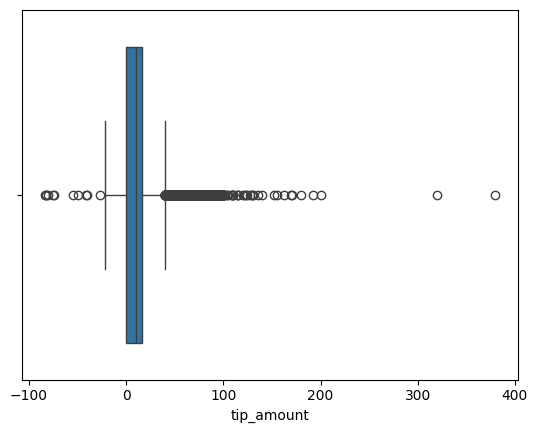

In [13]:
q1, q3 = df_132['tip_amount'].describe()['25%'], df_132['tip_amount'].describe()['75%']
iqr = q3 - q1
outliers = len(df_132[(df_132['tip_amount'] < q1 - 1.5*iqr) | (df_132['tip_amount'] > q3 + 1.5*iqr)])
print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_132) * 100):.2f}% of the data.")

sns.boxplot(x=df_132['tip_amount'])
plt.show()


Found 59377 outliers in 'trip_distance' - comprises 5.10% of the data.


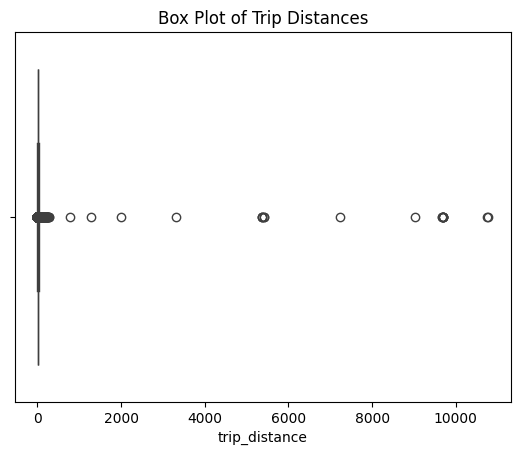

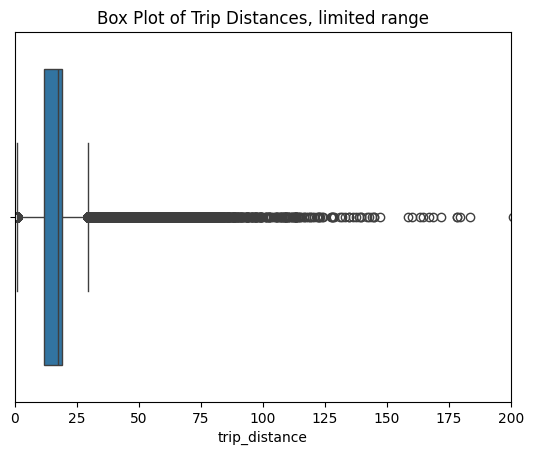

In [14]:
q1, q3 = df_132['trip_distance'].describe()['25%'], df_132['trip_distance'].describe()['75%']
iqr = q3 - q1
outliers = len(df_132[(df_132['trip_distance'] < q1 - 1.5*iqr) | (df_132['trip_distance'] > q3 + 1.5*iqr)])
print(f"Found {outliers} outliers in 'trip_distance' - comprises {(outliers / len(df_132) * 100):.2f}% of the data.")

sns.boxplot(x=df_132['trip_distance'])
plt.title("Box Plot of Trip Distances")
plt.show()

plt.title("Box Plot of Trip Distances, limited range")
sns.boxplot(x=df_132['trip_distance'])
plt.xlim(left=0, right=200)
plt.show()

From above, it seems most trips are between 0 and 200 miles. 

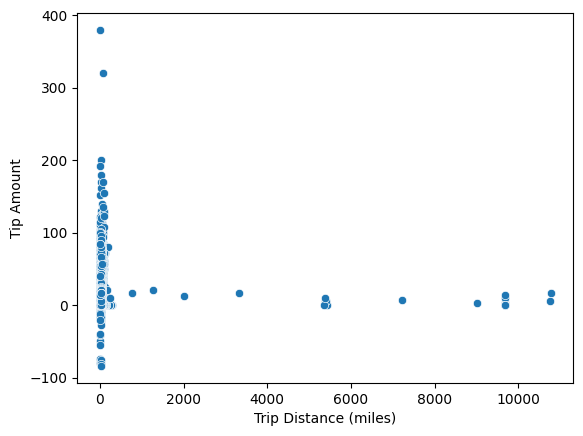

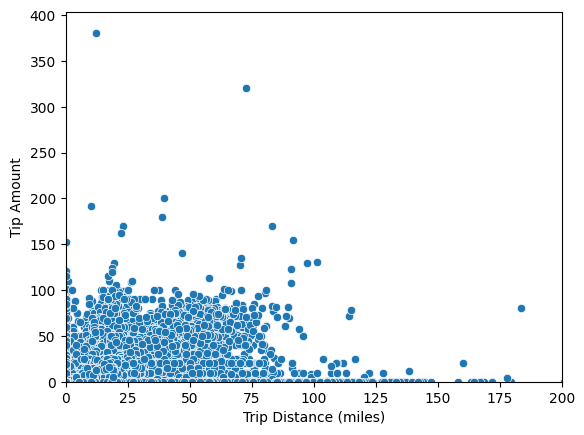

In [15]:
sns.scatterplot(data=df_132, x='trip_distance', y='tip_amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount')
plt.show()

# Remove outliers
sns.scatterplot(data=df_132, x='trip_distance', y='tip_amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount')
plt.xlim(left=0, right=200)
plt.ylim(bottom=0)
plt.show()

In the above graph, we notice a large cluster between trips that were 0-40 miles with tips that were tipped $0-$20.
We will investigate this further below.

We define short trips as trips less than 5 miles, medium trips as 5 to 20 miles, and long trips as 20+ miles.

In [16]:
bins = [0, 5, 20, float('inf')]
labels = ['short', 'medium', 'long']
df_132['trip_bin'] = pd.cut(df_132['trip_distance'], bins=bins, labels=labels)

print(df_132['trip_bin'].unique())

['medium', 'long', NaN, 'short']
Categories (3, object): ['short' < 'medium' < 'long']


Tips per Trip Calculation:

For bin short :
Mean tip: 2.143029508196722, median tip: 0.0, mode tip: 0.0
Skew: 4.380465493171194
Values are too skewed.


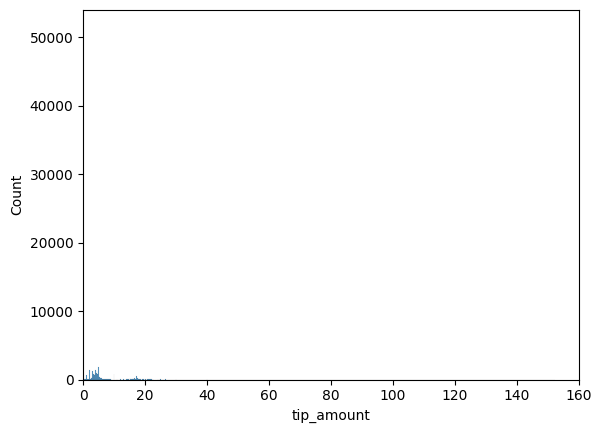

For bin medium :
Mean tip: 8.889484619995866, median tip: 10.0, mode tip: 0.0
Skew: 0.5939386544065538


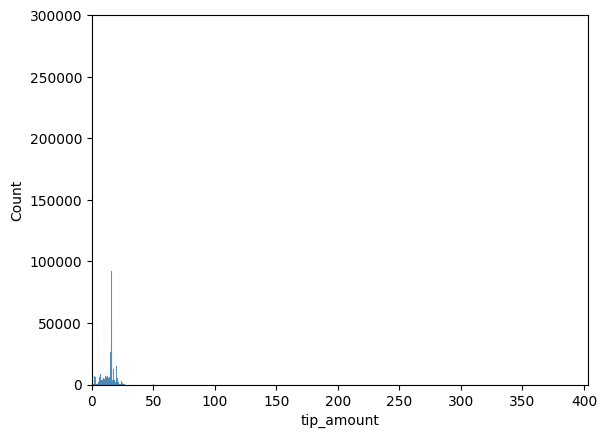

For bin long :
Mean tip: 11.832670159420045, median tip: 14.8, mode tip: 0.0
Skew: 1.5144460117919414
Values are too skewed.


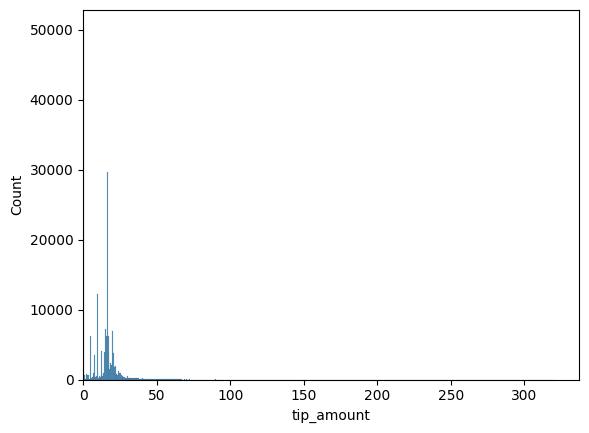

In [18]:
from scipy.stats import skew

for bin in ['short', 'medium', 'long']:
    print("For bin", bin, ":")
    tip_bin = df_132[df_132['trip_bin'] == bin]['tip_amount']
    print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
    # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
    skew_val = skew(tip_bin)
    print("Skew:", skew_val)
    if skew_val < -1 or skew_val > 1:
        print("Values are too skewed.")

    sns.histplot(data=tip_bin)
    plt.xlim(left=0)
    plt.show()

From above, we can determine long trips are the most profitable based on mean and median.

Evaluating Frequency and Demand Patterns

In [19]:
df_132['trip_bin'].value_counts()

trip_bin
medium    885793
long      178083
short      76250
Name: count, dtype: int64

From above, we can determine medium-length trips are in high demand, followed by long trips, then short trips. 

In [20]:
max_tip, max_bin = 0, "None"

for bin in ['short', 'medium', 'long']:
    tip_bin = df_132[df_132['trip_bin'] == bin]['tip_amount']
    expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_132['trip_bin']))
    print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
    if expected_tip > max_tip:
        max_bin = bin
        max_tip = expected_tip

print(f"For region 132, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")

Expected average tip for short trips: 0.14
Expected average tip for medium trips: 6.76
Expected average tip for long trips: 1.81
For region 132, the taxi company should prioritize medium trips, for an average expected tip of $6.76.


Assert the above using a hypothesis test.


Since we will be analyzing if there are 3 groups, each sampled from 3 non-normal distributions, we will apply the Kruskal-Wallis H-test, with $\alpha=0.05$.

Statistic values match those of the chi-squared test but with 1 less D.O.F. The relevant chi-squared value for 3 groups (D.O.F.=3) and $\alpha=0.05$ is 5.991 ([source](https://www.scribbr.com/statistics/chi-square-distribution-table/)) - the value for significance $\alpha-0.05$ and D.O.F. = 2.

In [21]:
from scipy.stats import kruskal

samples = [df_132[df_132['trip_bin'] == bin]['tip_amount'].sample(n=30, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
result = kruskal(*samples)
print(result)
print(result.statistic, result.pvalue)

if result.pvalue < 0.05:
    print("Reject the null hypothesis - there is significant difference between the groups.")
    if result.statistic > 5.991:
        print("Results are statistically significant.")
else:
    print("Failed to reject null hypothesis.")

KruskalResult(statistic=np.float64(21.252226593656722), pvalue=np.float64(2.427379227496243e-05))
21.252226593656722 2.427379227496243e-05
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.


Repeat this for all regions.

# Calculate best trip for each region.

Note that this involves running hypothesis tests within each region, not across all regions.

In [22]:
from scipy.stats import skew, kruskal

other_regions = []

def analyze_region(reg_id:int, bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Given the ID of a region (and optionally the bins for the trip distances), 
        perform the above analysis and return what length of trip gives the best tips 
        as well as its H-value and its significance.
    """

    if verbose: print(f"Examining region {reg_id}")
    df_region = df[df['PULocationID'] == reg_id][['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']]
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for region {reg_id}:")
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_amount'].describe()['25%'], df_region['tip_amount'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_amount'] < q1 - 1.5*iqr) | (df_region['tip_amount'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in region {reg_id}')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for {reg_id} - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in region {reg_id}")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in region {reg_id}")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in region {reg_id}, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_region['trip_bin']))
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For region {reg_id}, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_amount'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on region {reg_id}")
            other_regions.append(reg_id)
    except ValueError:
        print(f"Could not run hypothesis test on region {reg_id}")
        other_regions.append(reg_id)

    return {
        'region_id':reg_id,
        'short_tip':tips[0],
        'med_tip':tips[1],
        'long_tip':tips[2],
        'max_tip':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null':result.statistic > 5.991 if result else None
    }

In [23]:
def handle_others(bins = [0, 5, 20, float('inf')], min_entries=15, verbose=False)->int:
    """
        Repeats the analysis of analyze_region, but repeated for all regions that had too little data to be analyzed.
        We give these regions a unique ID of -1 to easily track them (as the other ID's map to real regions in NYC).
    """

    if verbose: print(f"Examining other regions")
    df_region = df[df['PULocationID'].isin(other_regions)]
    
    if verbose: 
        print(df_region.info())
        print("----------------------------")

        print(f"Number of missing values in relevant columns for other regions:")
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isna().sum())
        print(df_region[['tip_amount', 'trip_distance', 'PULocationID', 'DOLocationID']].isnull().sum())
        print("----------------------------")
    
    q1, q3 = df_region['tip_amount'].describe()['25%'], df_region['tip_amount'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['tip_amount'] < q1 - 1.5*iqr) | (df_region['tip_amount'] > q3 + 1.5*iqr)])
    
    if verbose: 
        print(f"Found {outliers} outliers in 'tip_amount' - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['tip_amount'])
        plt.title(f'Boxplot for tipping amount in other regions')
        plt.show()
        print("----------------------------")

    q1, q3 = df_region['trip_distance'].describe()['25%'], df_region['trip_distance'].describe()['75%']
    iqr = q3 - q1
    outliers = len(df_region[(df_region['trip_distance'] < q1 - 1.5*iqr) | (df_region['trip_distance'] > q3 + 1.5*iqr)])

    if verbose: 
        print(f"Found {outliers} outliers in 'trip_distance' for other regions - comprises {(outliers / len(df_region) * 100):.2f}% of the data.")

        sns.boxplot(x=df_region['trip_distance'])
        plt.title(f"Box Plot of Trip Distances in other regions")
        plt.show()

        plt.title(f"Box Plot of Trip Distances, limited range, in other regions")
        sns.boxplot(x=df_region['trip_distance'])
        plt.xlim(left=0, right=200)
        plt.show()
        print("----------------------------")

        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in other regions")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.show()

        # Remove outliers
        sns.scatterplot(data=df_region, x='trip_distance', y='tip_amount')
        plt.title(f"Scatter Plot of Trip Distances to Tip Amounts in other regions, without outliers")
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Tip Amount')
        plt.xlim(left=0, right=200)
        plt.ylim(bottom=0)
        plt.show()    
        print("----------------------------")

    labels = ['short', 'medium', 'long']
    df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)

    for bin in ['short', 'medium', 'long']:
        if verbose: print("For bin", bin, ":")
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        if verbose: print(f"Mean tip: {tip_bin.mean()}, median tip: {tip_bin.median()}, mode tip: {tip_bin.mode()[0]}")
        # print(f"Median tip, discarding zeros: {tip_bin[tip_bin > 0].median()}, mode tip, discarding zeros: {tip_bin[tip_bin > 0].mode()[0]}")
        
        if len(tip_bin) >= min_entries:
            skew_val = skew(tip_bin)
            if verbose: print("Skew:", skew_val)
            if skew_val < -1 or skew_val > 1:
                if verbose: print("Values are too skewed.")

        if verbose: 
            sns.histplot(data=tip_bin)
            plt.xlim(left=0)
            plt.show()

    if verbose: 
        print(f"Value count of each trip type in each region:\n{df_region['trip_bin'].value_counts()}")

        print("----------------------------")

    max_tip, max_bin = None, None
    tips = []

    for bin in ['short', 'medium', 'long']:
        tip_bin = df_region[df_region['trip_bin'] == bin]['tip_amount']
        expected_tip = tip_bin.mean() * (len(tip_bin) / len(df_region['trip_bin']))
        tips.append(expected_tip)
        if verbose: print(f"Expected average tip for {bin} trips: {expected_tip:.2f}")
        if not max_tip or expected_tip > max_tip:
            max_bin = bin
            max_tip = expected_tip

    print(f"For other regions, the taxi company should prioritize {max_bin} trips, for an average expected tip of ${max_tip:.2f}.")
    print("----------------------------")

    # Check if we have 30 points to sample.
    # If not, sample as much as we can.
    result = None

    try:
        bottleneck = min([len(df_region[df_region['trip_bin'] == bin]) for bin in ['short', 'medium', 'long']])
        if bottleneck >= min_entries:
            sample_number = min(bottleneck, 30)
            print(f"Sampling {sample_number} entries.")
            samples = [df_region[df_region['trip_bin'] == bin]['tip_amount'].sample(n=sample_number, random_state=42).to_list() for bin in ['short', 'medium', 'long']]
            
            result = kruskal(*samples)
            print(result)
            if verbose: print(result.statistic, result.pvalue)

            if result.pvalue < 0.05:
                print("Reject the null hypothesis - there is significant difference between the groups.")
                if result.statistic > 5.991:
                    print("Results are statistically significant.")
            else:
                print("Failed to reject null hypothesis.")
            print("----------------------------")

        else:
            print(f"Could not run hypothesis test on other regions")
    except ValueError:
        print(f"Could not run hypothesis test on other regions")

    return {
        'region_id':-1,
        'short_tip':tips[0],
        'med_tip':tips[1],
        'long_tip':tips[2],
        'max_tip':max_tip,
        'max_bin':max_bin,
        'is_statistically_significant':result.pvalue < 0.05 if result else None,
        'has_rejected_null':result.statistic > 5.991 if result else None
    }

In [24]:
locations = df['PULocationID'].unique()
results = []
for id in locations:
    # results.append(analyze_region(id, min_entries=1))
    results.append(analyze_region(id))

For region 262, the taxi company should prioritize short trips, for an average expected tip of $2.11.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(23.528005079046178), pvalue=np.float64(7.779624081434098e-06))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 229, the taxi company should prioritize short trips, for an average expected tip of $2.26.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(24.933717126168087), pvalue=np.float64(3.852229204456514e-06))
Reject the null hypothesis - there is significant difference between the groups.
Results are statistically significant.
----------------------------
For region 45, the taxi company should prioritize short trips, for an average expected tip of $1.79.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(5.83680577374464

In [25]:
results.append(handle_others())

For other regions, the taxi company should prioritize medium trips, for an average expected tip of $1.03.
----------------------------
Sampling 30 entries.
KruskalResult(statistic=np.float64(0.287664940657891), pvalue=np.float64(0.8660328221005715))
Failed to reject null hypothesis.
----------------------------


C:\Users\Py Torch\AppData\Local\Temp\ipykernel_32340\1587696075.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['trip_bin'] = pd.cut(df_region['trip_distance'], bins=bins, labels=labels)


In [26]:
results_df = pd.DataFrame(results)
print(results_df.isna().sum())
print(len(results_df))

region_id                        0
short_tip                        0
med_tip                          1
long_tip                         3
max_tip                          0
max_bin                          0
is_statistically_significant    79
has_rejected_null               79
dtype: int64
263


In [27]:
res_df = results_df.dropna()
print(len(res_df))

184


In [28]:
res_df.to_csv("analysis_data.csv", index=False)

# Read and Graph Data

In [29]:
res_df = pd.read_csv('analysis_data.csv')

In [30]:
colors = ['green' if is_significant else "gray" for is_significant in res_df['is_statistically_significant']]

# Plot avg tip for short, medium, and long trips for each cell.
graph= sns.catplot(data=res_df, kind='bar', color=colors, x='region_id', y='')
plt.show()

ValueError: Could not interpret value `` for `y`. An entry with this name does not appear in `data`.

# Analysis

Figure out a way to expand the above stats to something the company can use. This will be relevant for the midterm report.

Probably involves finding some way to map region id's to regions in NY.